# Sentiment analyse

### 1. Cформировать набор данных

#### 1.1. Загружаем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

In [2]:
import seaborn as sns
import re
import pymorphy2
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from string import punctuation

In [3]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

In [4]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from keras.models import Sequential
import tensorflow as tf
import tensorflow_addons as tfa

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kizum\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kizum\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#### 1.2. Загрузим данные

In [7]:
filename = 'train.json'
df = pd.read_json(filename, lines=True, encoding="utf8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6249 entries, 0 to 6248
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6249 non-null   object
 1   rating  6249 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 97.8+ KB


Посмотрим на 10 случайных строк в данных

In [8]:
df.sample(10, random_state=42)

,text,rating
2164,Достоинства: - Экран - Производительность - Ба...,5
611,Достоинства: -экран -стабильность системы -быс...,5
3524,"Достоинства: Быстрый, более менее камера.досто...",3
2292,Достоинства: Удобный интуитивный интерфейс без...,5
5084,\n Достоинства\n ...,5
476,Достоинства: Хорошо подогнанный корпус (без за...,4
2523,Достоинства: Цена/качество. Экран. Эргономично...,5
5538,\n Достоинства\n ...,5
3286,Достоинства: Отличный аппарат. Качественная сб...,5
5787,\n Достоинства\n ...,4


Напишем фунцию для очистки данных.

In [9]:
def cleaning(text):
    try:
        text = re.sub(r'Достоинства', ' ', text)
        text = re.sub(r'Недостатки', ' ', text)
        text = re.sub(r'Комментарий', ' ', text)
        text = ' '.join(text.split())
        return text
    except:
        return text

In [10]:
df['text'] = df.apply(lambda x: cleaning(x['text']), axis=1)
df['length'] = df['text'].apply(lambda x: len(x))
df['label'] = df['rating'].apply(lambda x: int(x == 5))
df.sample(10, random_state=42)

,text,rating,length,label
2164,: - Экран - Производительность - Батарейка - Д...,5,418,1
611,: -экран -стабильность системы -быстрая зарядк...,5,1385,1
3524,": Быстрый, более менее камера.достойный телефо...",3,215,0
2292,": Удобный интуитивный интерфейс без тормозов, ...",5,629,1
5084,Быстрая зарядка. Долго держит заряд(15 часов и...,5,637,1
476,": Хорошо подогнанный корпус (без зазоров), дов...",4,354,0
2523,": Цена/качество. Экран. Эргономичность, 4 гига...",5,403,1
5538,Для меня форм фактор(именно компактный размер!...,5,137,1
3286,: Отличный аппарат. Качественная сборка. По ве...,5,486,1
5787,Достаточная производительность для многозадачн...,4,1918,0


#### 1.3. Визуальный анализ данных

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,6249.0,4.445511,0.985953,1.0,4.0,5.0,5.0,5.0
length,6249.0,907.683149,822.487739,9.0,322.0,658.0,1238.0,6082.0
label,6249.0,0.679149,0.466841,0.0,0.0,1.0,1.0,1.0


Набор данных содержит 6249 отзывов в диапазоне от 1 до 5.

Посмотрим на распределение меток и оценок отзывов.


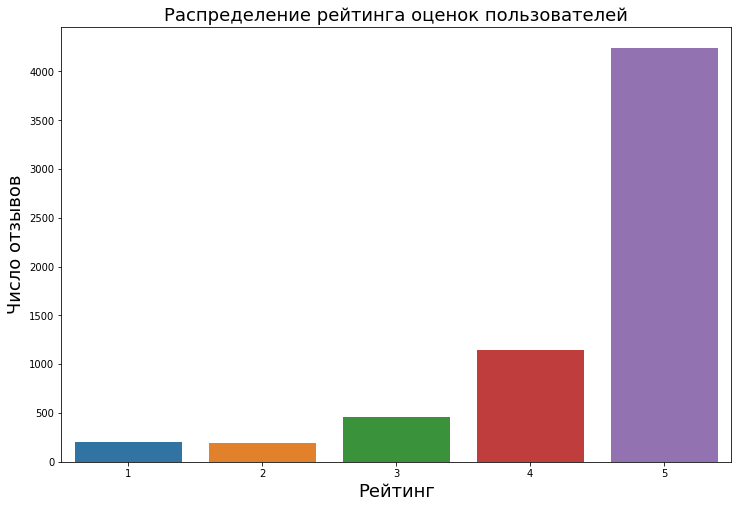

In [12]:
fig = plt.figure(figsize=(12, 8))
sns.countplot(x='rating', data=df)
plt.title("Распределение рейтинга оценок пользователей", size=18)
plt.xlabel("Рейтинг", size=18)
plt.ylabel("Число отзывов", size=18)
plt.show()

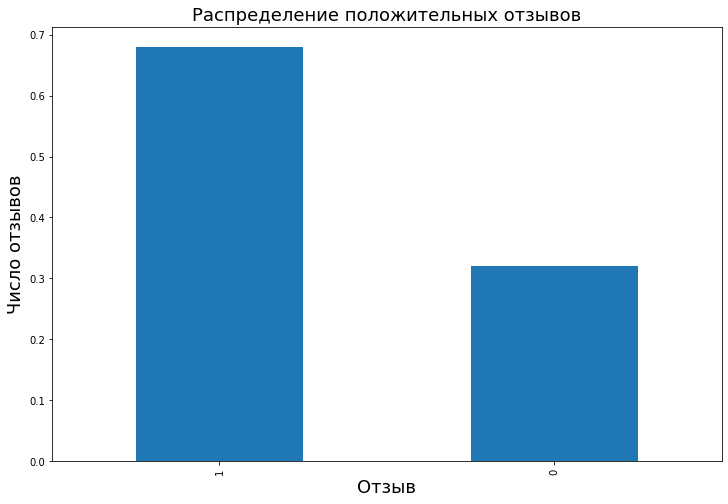

In [13]:
fig = plt.figure(figsize=(12, 8))
df['label'].value_counts(normalize=True).plot(kind='bar');
plt.title("Распределение положительных отзывов", size=18);
plt.xlabel("Отзыв", size=18);
plt.ylabel("Число отзывов", size=18);

Text(0, 0.5, 'Количество текстов')

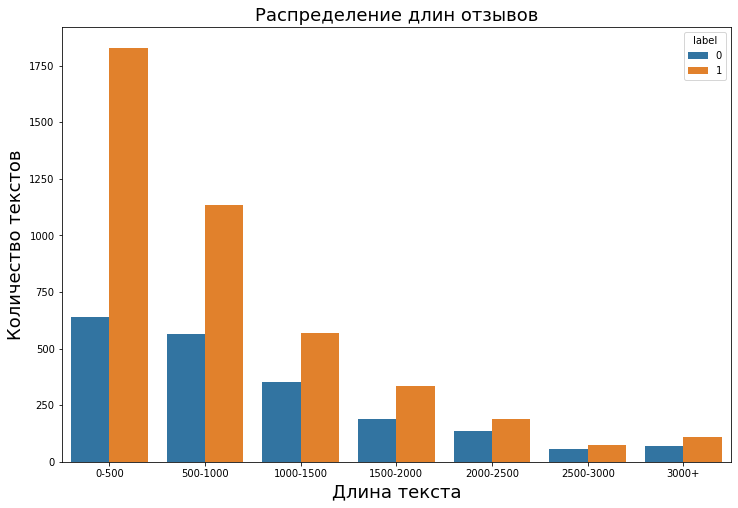

In [14]:
df['length_interval'] = pd.cut(df['length'], bins=[0, 500, 1000, 1500, 2000, 2500,  3000, float('inf')], 
                      labels=['0-500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '3000+'])

fig = plt.figure(figsize=(12, 8))
sns.countplot(x='length_interval', hue='label', data=df)
plt.title("Распределение длин отзывов", size=18)
plt.xlabel("Длина текста", size=18)
plt.ylabel("Количество текстов", size=18)

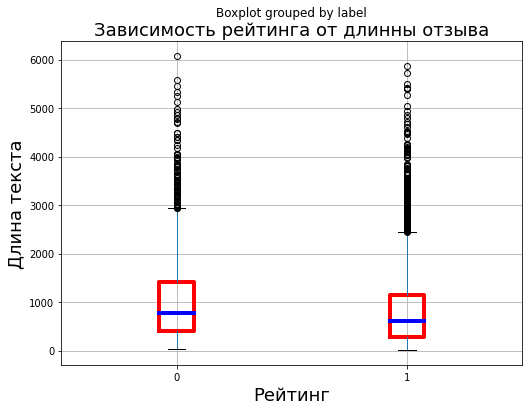

In [15]:
boxprops = dict(linestyle='-', linewidth=4, color='r')
medianprops = dict(linestyle='-', linewidth=4, color='b')
df.boxplot(column=['length'], by='label', figsize=(8, 6), boxprops=boxprops, medianprops=medianprops)
plt.title("Зависимость рейтинга от длинны отзыва", size=18)
plt.xlabel("Рейтинг", size=18)
plt.ylabel("Длина текста", size=18)
plt.show()

При взгляде на данную гистограмму, может показаться что короткие отзывы в среднем более позиитивны, хотя на самом деле, имеет место обратная зависимость. Как правило чем хуже отзыв - тем он длиннеее.

### 2. Предварительная обработка данных

#### 2.1. UnderSampling

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
(X_train.shape, X_test.shape), (y_train.shape, y_test.shape)

(((4999,), (1250,)), ((4999,), (1250,)))

In [21]:
ros = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = ros.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train.to_numpy())
X_train_undersampled = X_train_undersampled.reshape(-1)
(X_train_undersampled.shape, X_test.shape), (y_train_undersampled.shape, y_test.shape)

(((3184,), (1250,)), ((3184,), (1250,)))

In [22]:
print('Train:\t\t\t{}'.format(len(y_train)))
print('Udnersampling:\t\t{}'.format(len(y_train_undersampled)))
print('Deleted:\t\t{}'.format(len(y_train) - len(y_train_undersampled)))

Train:			4999
Udnersampling:		3184
Deleted:		1815


#### 2.2. Токенизация

In [146]:
tokenizer = Tokenizer(filters=punctuation)
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1

X_train_split = tokenizer.texts_to_sequences(np.array(X_train_undersampled))
X_test_split = tokenizer.texts_to_sequences(np.array(X_test))

maxlen = int(np.percentile(np.array([len(i) for i in X_train_split] + [len(i) for i in X_test_split]), 95))

X_train_split = pad_sequences(X_train_split, padding='post', maxlen=maxlen)
X_test_split = pad_sequences(X_test_split, padding='post', maxlen=maxlen)

print('Maxlen: {}'.format(maxlen))

Maxlen: 386


In [147]:
print('\nИсходный текст:')
print(X_test.iloc[13])

print('\nТокенезированный текст:')
print(X_test_split[13])


Исходный текст:
: Отличный телефон, очень доволен покупкой, батарея держит в режиме постоянного пользования очень долго к вечеру остается еще 40%, камера превосходная, скорость работы потрясающая - берите и не думайте! : Да слот памяти, да не сменный аккумулятор - все мелочи по сравнению с достоинствами. Отпечаток пальца как то работает не очень, отключил его. :

Токенезированный текст:
[  73    9    8  128  321   57   79    3  188 4691  475    8  123   27
 2176  897   84  678   20 6148  231   95 5671  442    1    2 6322   87
  570   55   87    2 8891  109   15 1309   13  361    5 5233  488  227
   14   16   43    2    8 2366   44    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 

#### 2.3. Создание базовой модели

Для того чтобы оценить влияние которое оказывает предобработка данных на модель, создадим baseline модель линейной регрессии. Будем выполнять оценку по следующим метрикам.

- Accuracy - среднее чтсло ошибок модели, данная метрика в отличии от последующих чуствительна к несбалансированности выборки.
- Precision - в данном случае будет отражать долю действительно положительных отзывов среди всех отзывов отнесенных к положительным (поскольку мы в данном случае выполняем предсказание положиетльных отзывов).
- Recall -в данном случае будет отражать долю найденных положительных отзывов среди всех положительных отзывов (поскольку мы в данном случае выполняем предсказание положиетльных отзывов).
- F1 score - среднее гармоническое precision и recall, данная метрика довольно популярна, поскольку также как precision и recall не чусвительна к несбалонсированным выборкам и при этом требует чтобы обе эти метрики имели достаточно высокое значение.

In [29]:
def make_cross_val_estimation(clf, X, y, cv=3, score_round_ord=4, time_round_ord=6, show_time=False,
                    scoring={'Accuracy': make_scorer(accuracy_score, greater_is_better=True),
                             'Precision': make_scorer(precision_score, greater_is_better=True),
                             'Recall': make_scorer(recall_score, greater_is_better=True),
                             'F1': make_scorer(f1_score, greater_is_better=True),
                             'AUC': make_scorer(roc_auc_score, greater_is_better=True)}):
    
    reg_scores = cross_validate(clf, X, y, cv=cv, scoring=scoring)
    for score_name in scoring:
        score_key = 'test_' + score_name
        reg_scores[score_key] = reg_scores[score_key].mean()
        print('Model {}: {}'.format(score_name, round(reg_scores[score_key], score_round_ord)))
    
    if show_time:
        reg_scores['fit_time'] = reg_scores['fit_time'].mean() * 1000
        print('\nMean fit time {}ms'.format(round(reg_scores['fit_time'], time_round_ord)))
        
        reg_scores['score_time'] = reg_scores['score_time'].mean() * 1000
        print('Mean score time {}ms'.format(round(reg_scores['score_time'], time_round_ord)))
    
    return reg_scores

In [30]:
def make_estimation(clf, X, y, score_round_ord=4,
               scoring={'Accuracy': make_scorer(accuracy_score, greater_is_better=True),
                        'Precision': make_scorer(precision_score, greater_is_better=True),
                        'Recall': make_scorer(recall_score, greater_is_better=True),
                        'F1': make_scorer(f1_score, greater_is_better=True),
                        'AUC': make_scorer(roc_auc_score, greater_is_better=True)}):
    reg_scores = {}
    for score_name in scoring:
        score_key = 'test_' + score_name
        reg_scores[score_key] = scoring[score_name](clf, X, y)
        print('Model {}: {}'.format(score_name, round(reg_scores[score_key], score_round_ord)))
    
    return reg_scores

In [31]:
def make_comparisons(results1, results2, score_round_ord=4):
    for score_name in results1:
        if score_name.startswith('test_'):
            compare =  round(results1[score_name] -  results2[score_name], score_round_ord)
            sign = '+' if compare > 0 else ''
            print('{} changes: {}{}'.format(score_name.removeprefix('test_'), sign, compare))
    print('\n')

In [132]:
base_model_clf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(random_state=42))
])

Base model cross val estimation

Model Accuracy: 0.7085
Model Precision: 0.7016
Model Recall: 0.7267
Model F1: 0.7137
Model AUC: 0.7085

Base model estimation

Model Accuracy: 0.7344
Model Precision: 0.8464
Model Recall: 0.7372
Model F1: 0.788
Model AUC: 0.733


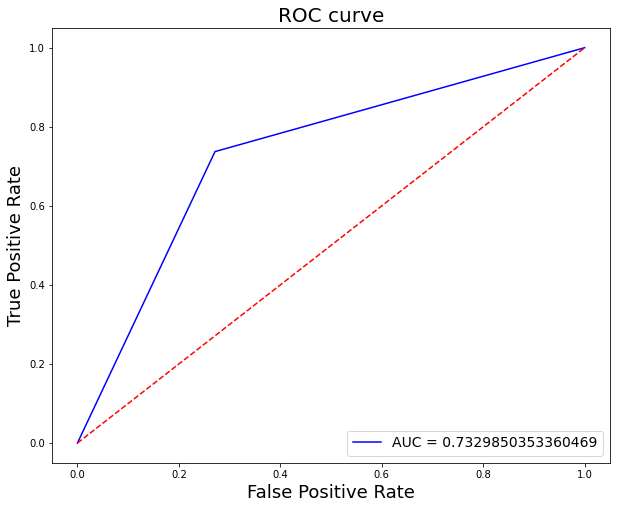

In [133]:
from sklearn.metrics import roc_curve, roc_auc_score

print('Base model cross val estimation\n')
base_model_cross_score = make_cross_val_estimation(base_model_clf, X_train_undersampled, y_train_undersampled)

print('\nBase model estimation\n')
base_model_score = make_estimation(base_model_clf.fit(X_train_undersampled, y_train_undersampled), X_test, y_test)


fpr, tpr, thresholds = roc_curve(y_test, base_model_clf.fit(X_train_undersampled, y_train_undersampled).predict(X_test))
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(10, 8))

plt.title('ROC curve', size=20)
plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(roc_auc))
plt.legend(loc = 'lower right', fontsize=14)
plt.plot([0, 1], [0, 1],'r--')

plt.ylabel('True Positive Rate', size=18)
plt.xlabel('False Positive Rate', size=18)
plt.show()

### 3. Обучение модели нейронной сети

#### 3.1 Нейронаня сеть

In [34]:
from keras import backend as K

def F1Score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [152]:
from tensorflow import keras

embedding_dim = 60

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(GlobalMaxPooling1D())

model.add(Dense(400, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(400, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(Dense(400, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(400, activation='relu'))
model.add(keras.layers.Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='Precision'), 
                       tf.keras.metrics.Recall(name='Recall'),
                       F1Score,
                       tf.keras.metrics.AUC(name='AUC')])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 386, 60)           3189120   
                                                                 
 global_max_pooling1d_21 (Gl  (None, 60)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_92 (Dense)            (None, 400)               24400     
                                                                 
 dropout_71 (Dropout)        (None, 400)               0         
                                                                 
 dense_93 (Dense)            (None, 400)               160400    
                                                                 
 dropout_72 (Dropout)        (None, 400)               0         
                                                     

In [153]:
history = model.fit(X_train_split, y_train_undersampled, epochs=10, validation_data=(X_test_split, y_test))

Epoch 1/10
100/100 [==============================] - 4s 32ms/step - loss: 0.6966 - accuracy: 0.4956 - Precision: 0.4947 - Recall: 0.4114 - F1Score: 0.3409 - AUC: 0.5025 - val_loss: 0.6887 - val_accuracy: 0.6696 - val_Precision: 0.6696 - val_Recall: 1.0000 - val_F1Score: 0.8024 - val_AUC: 0.5023
Epoch 2/10
100/100 [==============================] - 3s 26ms/step - loss: 0.6937 - accuracy: 0.4997 - Precision: 0.4997 - Recall: 0.4830 - F1Score: 0.4364 - AUC: 0.5029 - val_loss: 0.6788 - val_accuracy: 0.6696 - val_Precision: 0.6696 - val_Recall: 1.0000 - val_F1Score: 0.8024 - val_AUC: 0.6802
Epoch 3/10
100/100 [==============================] - 3s 26ms/step - loss: 0.6506 - accuracy: 0.6131 - Precision: 0.6100 - Recall: 0.6269 - F1Score: 0.5919 - AUC: 0.6640 - val_loss: 0.7261 - val_accuracy: 0.5424 - val_Precision: 0.9003 - val_Recall: 0.3560 - val_F1Score: 0.4928 - val_AUC: 0.7583
Epoch 4/10
100/100 [==============================] - 3s 27ms/step - loss: 0.4321 - accuracy: 0.8172 - Precis

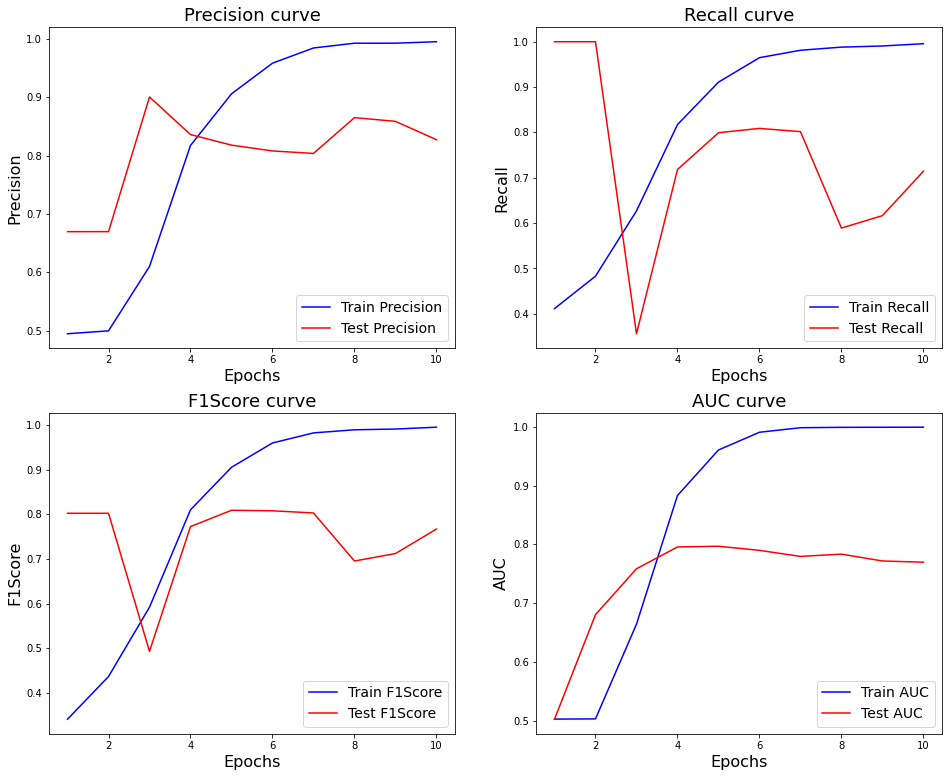

In [154]:
fig = plt.figure(figsize=(16, 13))
epocshs = np.arange(1, 11)

lab = ['Precision', 'Recall', 'F1Score', 'AUC']
for n, l in enumerate(lab ):
    plt.subplot(2, 2, n + 1)
    plt.title(str(l) + ' curve', size=18)
    plt.plot(epocshs, history.history[l][:10], 'b', label = 'Train {}'.format(l))
    plt.plot(epocshs, history.history['val_' + l][:10], 'r', label = 'Test {}'.format(l))
    plt.legend(loc = 'lower right', fontsize=14)
    plt.ylabel(str(l), size=16)
    plt.xlabel('Epochs', size=16)
plt.show()

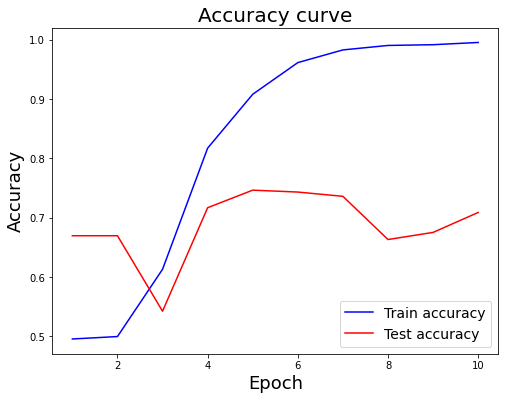

NN model best results on 4 epoch 

Best epoch Accuracy:	0.7464
Best epoch Precision:	0.8178
Best epoch Recall:	0.7993
Best epoch F1Score:	0.8091
Best epoch AUC:		0.7967

NN vs LogRegression

Accuracy changes: +0.012
Precision changes: -0.0285
Recall changes: +0.0621
F1 changes: +0.0211
AUC changes: +0.0637




In [155]:
fig = plt.figure(figsize=(8, 6))
epocshs = np.arange(1, 11)

plt.title('Accuracy curve', size=20)
plt.plot(epocshs, history.history['accuracy'], 'b', label = 'Train accuracy')
plt.plot(epocshs, history.history['val_accuracy'], 'r', label = 'Test accuracy')
plt.legend(loc = 'lower right', fontsize=14)

plt.ylabel('Accuracy', size=18)
plt.xlabel('Epoch', size=18)
plt.show()

n_best_epoch = list(history.history['val_F1Score']).index(max(history.history['val_F1Score']))
print('NN model best results on {} epoch \n'.format(n_best_epoch))
print('Best epoch Accuracy:\t{}'.format(round(history.history['val_accuracy'][n_best_epoch], 4)))
print('Best epoch Precision:\t{}'.format(round(history.history['val_Precision'][n_best_epoch], 4)))
print('Best epoch Recall:\t{}'.format(round(history.history['val_Recall'][n_best_epoch], 4)))
print('Best epoch F1Score:\t{}'.format(round(history.history['val_F1Score'][n_best_epoch], 4)))
print('Best epoch AUC:\t\t{}'.format(round(history.history['val_AUC'][n_best_epoch], 4)))

NN_model_score = {
    'test_Accuracy': history.history['val_accuracy'][n_best_epoch],
    'test_Precision': history.history['val_Precision'][n_best_epoch],
    'test_Recall': history.history['val_Recall'][n_best_epoch],
    'test_F1': history.history['val_F1Score'][n_best_epoch],
    'test_AUC': history.history['val_AUC'][n_best_epoch],
}

print('\nNN vs LogRegression\n')
make_comparisons(NN_model_score, base_model_score)